In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%pip install -q -U 'google-generativeai>=0.8.3'

In [ ]:
import google.generativeai as genai
from IPython.display import Markdown, HTML, display

In [ ]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
for model in genai.list_models():
    if "002" in model.name:
        print(model.name)

In [ ]:
# Ask for information without search grounding.
model = genai.GenerativeModel("gemini-1.5-flash-002")

response = model.generate_content("When and where is Taylor Swift's next concert?")

Markdown(response.text)

In [ ]:
# And now re-run the same query with search grounding enabled.
model = genai.GenerativeModel(
    "gemini-1.5-flash-002",
    tools="google_search_retrieval")

response = model.generate_content("When and where is Taylor Swift's next concert?")
rc = response.candidates[0]

Markdown(rc.content.parts[0].text)

In [ ]:
chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(chunk)

In [ ]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

In [ ]:
supports = rc.grounding_metadata.grounding_supports
for support in supports:
    print(support)

In [ ]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        response.text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"* {i}: [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

In [ ]:
nosearch_model = genai.GenerativeModel("gemini-1.5-flash-002")
chat = nosearch_model.start_chat()

# No search grounding.
r = chat.send_message("Hello friendly chatbot!")

# Enable search for just this turn.
r = chat.send_message(
    "Who took home the 2023 cricket world cup?", tools="google_search_retrieval"
)

Markdown(r.text)

In [ ]:
HTML(r.candidates[0].grounding_metadata.search_entry_point.rendered_content)

In [ ]:
# The dynamic retrieval score is a probability, so the threshold
# must also be bound by [0, 1].
search_config = {
    "dynamic_retrieval_config": {"mode": "MODE_DYNAMIC", "dynamic_threshold": 0.5}
}

maybe_search_model = genai.GenerativeModel(
    "gemini-1.5-flash-002", tools={"google_search_retrieval": search_config}
)

chat = maybe_search_model.start_chat()

r = chat.send_message("Hello friendly chatbot!")
rc = r.candidates[0]
score = rc.grounding_metadata.retrieval_metadata.google_search_dynamic_retrieval_score
print(f"First turn: {score=}")

r = chat.send_message("Who took home the 2023 cricket world cup?")
rc = r.candidates[0]
score = rc.grounding_metadata.retrieval_metadata.google_search_dynamic_retrieval_score
print(f"Second turn: {score=}")
print()

display(Markdown(r.text))

In [ ]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

In [1]:
%pip install -U -q 'google-generativeai>=0.8.3'

Note: you may need to restart the kernel to use updated packages.


In [2]:
import google.generativeai as genai

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

In [4]:
for model in genai.list_models():
    if "createTunedModel" in model.supported_generation_methods:
        print(model.name)

models/gemini-1.0-pro-001
models/gemini-1.5-flash-001-tuning


In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [7]:
import email
import re

import pandas as pd


def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate the text to fit within the input limits
    text = text[:40000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df


In [9]:
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


In [10]:
def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]
    df["Class Name"] = df["Class Name"].astype("category")

    return df


TRAIN_NUM_SAMPLES = 50
TEST_NUM_SAMPLES = 10
# Keep rec.* and sci.*
CLASSES_TO_KEEP = "^rec|^sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [11]:
sample_idx = 0
sample_row = preprocess_newsgroup_row(newsgroups_test.data[sample_idx])
sample_label = newsgroups_test.target_names[newsgroups_test.target[sample_idx]]

print(sample_row)
print('---')
print('Label:', sample_label)

Need info on 88-89 Bonneville


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler

---
Label: rec.autos


In [12]:
baseline_model = genai.GenerativeModel("gemini-1.5-flash-001")
response = baseline_model.generate_content(sample_row)
print(response.text)

You're right, the 1988-89 Bonneville models can be confusing with their different trims! Here's a breakdown to help you out:

**1988-1989 Pontiac Bonneville Trim Levels:**

* **LE:** This was the base model, offering standard features but lacking some of the luxuries found in the higher trims.
* **SE:** This trim level added some comfort and style upgrades, including power windows, locks, and mirrors, as well as cloth upholstery.
* **LSE:** This was a step up from the SE, offering more features like a sunroof, upgraded interior materials, and additional options like a rear defroster and air conditioning. 
* **SSE:**  This trim level was the sporty option. It featured a more powerful engine (often the 3.8L V6 with a higher horsepower rating), firmer suspension for improved handling, and unique exterior styling cues. 
* **SSEi:** This was the top-of-the-line model, offering the SSE's sporty performance and a luxurious interior with leather upholstery,  woodgrain trim, and a more powerful

In [13]:
# Ask the model directly in a zero-shot prompt.

prompt = "From what newsgroup does the following message originate?"
baseline_response = baseline_model.generate_content([prompt, sample_row])
print(baseline_response.text)

The message most likely originates from a newsgroup dedicated to **Pontiac automobiles**, specifically the **Bonneville model**.  

Here's why:

* **The Topic:** The entire message revolves around the Pontiac Bonneville, specifically the 1988-1989 models.
* **Model Specificity:**  The message mentions various trim levels (LE, SE, LSE, SSE, SSEi), indicating a focused discussion on these specific Bonnevilles. 
* **Timing:** The mention of "mid-spring early summer" as the best time to buy suggests a seasonal discussion common in car-related newsgroups.

While there might be other newsgroups tangentially related (like general car buying or classic car enthusiast forums), the content strongly points to a Pontiac Bonneville-specific newsgroup. 



In [14]:
from google.api_core import retry

# You can use a system instruction to do more direct prompting, and get a
# more succinct answer.

system_instruct = """
You are a classification service. You will be passed input that represents
a newsgroup post and you must respond with the newsgroup from which the post
originates.
"""

instructed_model = genai.GenerativeModel("gemini-1.5-flash-001",
                                         system_instruction=system_instruct)

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# If you want to evaluate your own technique, replace this function with your
# model, prompt and other code and return the predicted answer.
def predict_label(post: str) -> str:
    response = instructed_model.generate_content(post, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        # Clean up the response.
        return response.text.strip()


prediction = predict_label(sample_row)

print(prediction)
print()
print("Correct!" if prediction == sample_label else "Incorrect.")

rec.autos.misc

Incorrect.


In [15]:
from tqdm.rich import tqdm

tqdm.pandas()


# Further sample the test data to be mindful of the free-tier quota.
df_baseline_eval = sample_data(df_test, 2, '.*')

# Make predictions using the sampled data.
df_baseline_eval['Prediction'] = df_baseline_eval['Text'].progress_apply(predict_label)

# And calculate the accuracy.
accuracy = (df_baseline_eval["Class Name"] == df_baseline_eval["Prediction"]).sum() / len(df_baseline_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/opt/conda/lib/python3.10/site-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy: 18.75%


In [16]:
df_baseline_eval

,Text,Label,Class Name,Prediction
0,Re: Mercury Villager Minivan -- good buy?\n\nI...,7,rec.autos,rec.autos.misc
1,Re: REVIEW: 1989 Ford Taurus SHO\n\n\nIn artic...,7,rec.autos,rec.autos.sports-cars
2,Re: dogs\n\n21 Apr 1993 (Ed Green - Pixel Cru...,8,rec.motorcycles,rec.motorcycles
3,Re: Inner tube in tyre... Safe ?\n\nSpeedy Mer...,8,rec.motorcycles,rec.autos.motorcycle
4,"Re: CUB fever.\n\n\nIn article <>, (Orin Roth...",9,rec.sport.baseball,rec.sports.baseball.misc
5,"Re: MLB = NBA?\n\nIn article <>, (King Banaia...",9,rec.sport.baseball,rec.sports.baseball
6,Re: Wings will win\n\n (Greg Ballentine) writ...,10,rec.sport.hockey,rec.sports.hockey
7,Re: SHARKS: Jack Feirerra (was Re: SHARKS: Kin...,10,rec.sport.hockey,rec.sports.hockey
8,Re: New Encryption Algorithm\n\n \n>In article...,11,sci.crypt,(error)
9,Re: Do we need the clipper for cheap security?...,11,sci.crypt,(error)


In [17]:
from collections.abc import Iterable
import random


# Append a random number to the model ID so you can re-run with a higher chance
# of creating a unique model ID.
model_id = f"newsgroup-classifier-{random.randint(10000, 99999)}"

# Upload the training data and queue the tuning job.
tuning_op = genai.create_tuned_model(
    "models/gemini-1.5-flash-001-tuning",
    training_data=df_train,
    input_key="Text",  # the column to use as input
    output_key="Class Name",  # the column to use as output
    id=model_id,
    display_name="Newsgroup classification model",
    batch_size=16,
    epoch_count=2,
)

print(model_id)

newsgroup-classifier-76383


State.CREATING
State.CREATING
State.CREATING
State.CREATING
State.CREATING
Done! The model is ACTIVE


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='step', ylabel='mean_loss'>

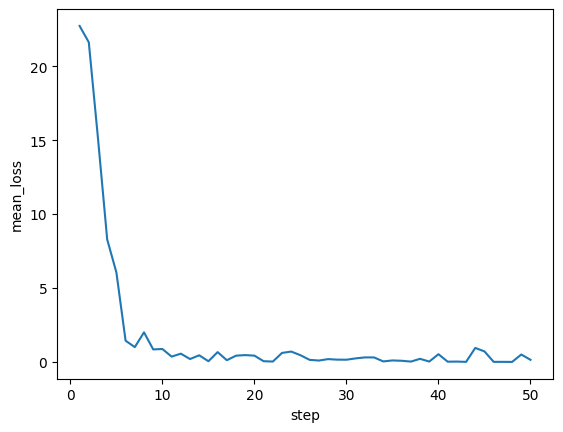

In [18]:
import time
import seaborn as sns


while (tuned_model := genai.get_tuned_model(f"tunedModels/{model_id}")).state.name != 'ACTIVE':

    print(tuned_model.state)
    time.sleep(60)

print(f"Done! The model is {tuned_model.state.name}")

# Plot the loss curve.
snapshots = pd.DataFrame(tuned_model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x="step", y="mean_loss")

In [19]:
your_model = genai.GenerativeModel(f"tunedModels/{model_id}")

new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = your_model.generate_content(new_text)
print(response.text)

sci.space


In [20]:
def classify_text(text: str) -> str:
    """Classify the provided text into a known newsgroup."""
    response = your_model.generate_content(text, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        return rc.content.parts[0].text


# The sampling here is just to minimise your quota usage. If you can, you should
# evaluate the whole test set with `df_model_eval = df_test.copy()`.
df_model_eval = sample_data(df_test, 4, '.*')


df_model_eval["Prediction"] = df_model_eval["Text"].progress_apply(classify_text)

accuracy = (df_model_eval["Class Name"] == df_model_eval["Prediction"]).sum() / len(df_model_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/opt/conda/lib/python3.10/site-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy: 84.38%


In [21]:
# Calculate the *input* cost of the baseline model with system instructions.
sysint_tokens = instructed_model.count_tokens(sample_row).total_tokens
print(f'System instructed baseline model: {sysint_tokens} (input)')

# Calculate the input cost of the tuned model.
tuned_tokens = your_model.count_tokens(sample_row).total_tokens
print(f'Tuned model: {tuned_tokens} (input)')

savings = (sysint_tokens - tuned_tokens) / tuned_tokens
print(f'Token savings: {savings:.2%}')  # Note that this is only n=1.

System instructed baseline model: 171 (input)
Tuned model: 135 (input)
Token savings: 26.67%


In [22]:
baseline_token_output = baseline_response.usage_metadata.candidates_token_count
print('Baseline (verbose) output tokens:', baseline_token_output)

tuned_model_output = your_model.generate_content(sample_row)
tuned_tokens_output = tuned_model_output.usage_metadata.candidates_token_count
print('Tuned output tokens:', tuned_tokens_output)

Baseline (verbose) output tokens: 165
Tuned output tokens: 4
